In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import cross_val_score

2023-09-20 00:52:13.743041: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-20 00:52:13.745107: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-20 00:52:13.781058: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-20 00:52:13.782198: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-20 00:52:14.436705: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# Load the data
data = pd.read_csv('../dataset/node1_data.csv')

In [3]:
data['needs_charge'] = np.where(data['charge'] <= 50, 1, 0)

DATA CLEANING

In [4]:
# Data Cleaning
data = pd.get_dummies(data, columns=['weather', 'traffic', 'road_gradient', 'emergency', 'car_status'])

# Check the column names
print(data.columns)

Index(['timestamp', 'car_id', 'model', 'current_speed', 'battery_capacity',
       'charge', 'consumption', 'location', 'node', 'distance_covered',
       'battery_life', 'distance_to_charging_point', 'emergency_duration',
       'needs_charge', 'weather_rainy', 'weather_snowy', 'weather_sunny',
       'traffic_heavy', 'traffic_light', 'traffic_moderate',
       'road_gradient_downhill', 'road_gradient_flat', 'road_gradient_uphill',
       'emergency_accident_ahead', 'emergency_none', 'emergency_road_closure',
       'car_status_Moving', 'car_status_moving', 'car_status_rerouting',
       'car_status_stopped'],
      dtype='object')


In [5]:
## Remove duplicates
data = data.drop_duplicates()

# Drop other non-numeric columns if any
data = data.select_dtypes(include=[float, int])

In [6]:
## Handle outliers
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

for column in data.columns:
    median = data[column].median()
    data.loc[((data[column] < (Q1[column] - 1.5 * IQR[column])) | (data[column] > (Q3[column] + 1.5 * IQR[column]))), column] = median

Feature Selection

In [7]:
# Feature Selection
features = ['current_speed', 'battery_capacity', 'charge', 'consumption', 'distance_covered', 'battery_life', 'distance_to_charging_point']
features += [col for col in data if 'weather_' in col]
features += [col for col in data if 'traffic_' in col]
features += [col for col in data if 'road_gradient_' in col]
features += [col for col in data if 'emergency_' in col]
features += [col for col in data if 'car_status_' in col]

X = data[features]
y = data['needs_charge']

print(X.head())

   current_speed  battery_capacity     charge  consumption  distance_covered  \
0             21                50  68.879922         0.13          0.833333   
1             43                50  77.714729         0.12          1.333333   
2             53                50  77.633644         0.12          2.050000   
3             52                50  77.509634         0.12          2.933333   
4             32                50  77.390325         0.12          3.800000   

   battery_life  distance_to_charging_point  emergency_duration  
0        97.999                   39.166667                   0  
1        98.999                   88.666667                   0  
2        98.998                   87.950000                   0  
3        98.997                   87.066667                   0  
4        98.996                   86.200000                   0  


In [8]:
# Create a copy of the DataFrame slice
X = X.copy()

# Display columns which contain 'inf' or '-inf' values
inf_columns = X.columns[X.isin([float('inf'), -float('inf')]).any()].tolist()
print(f"Columns with inf values: {inf_columns}")

# Replace 'inf' and '-inf' values in those columns with NaN
for col in inf_columns:
    X[col].replace([float('inf'), -float('inf')], float('nan'), inplace=True)

# Optionally, fill NaN values with a specified value or method
# Here, we're replacing NaN with the mean of the column
for col in inf_columns:
    X[col].fillna(X[col].mean(), inplace=True)

Columns with inf values: []


In [9]:
# RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Initialize the model with higher max_iter
model = LogisticRegression(max_iter=1000)

# Initialize RFE
rfe = RFE(model, n_features_to_select=10)  # change the number of features to select as needed

# Fit RFE
fit = rfe.fit(X, y)

# Get the selected features
selected_features = X.columns[fit.support_]
print("Selected Features: ", selected_features)

Selected Features:  Index(['current_speed', 'battery_capacity', 'charge', 'consumption',
       'distance_covered', 'battery_life', 'distance_to_charging_point',
       'emergency_duration'],
      dtype='object')


In [10]:
print(data['charge'].describe())
print(data['needs_charge'].value_counts())


count    9662.000000
mean       61.470469
std        21.442255
min         0.000000
25%        41.592330
50%        57.078808
75%        82.824401
max        99.819461
Name: charge, dtype: float64
0    6131
1    3531
Name: needs_charge, dtype: int64


In [11]:
print(data['needs_charge'].value_counts())

0    6131
1    3531
Name: needs_charge, dtype: int64


In [12]:
# # Data Splitting
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Data Splitting using selected features
X_selected = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

In [13]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Data Visualization

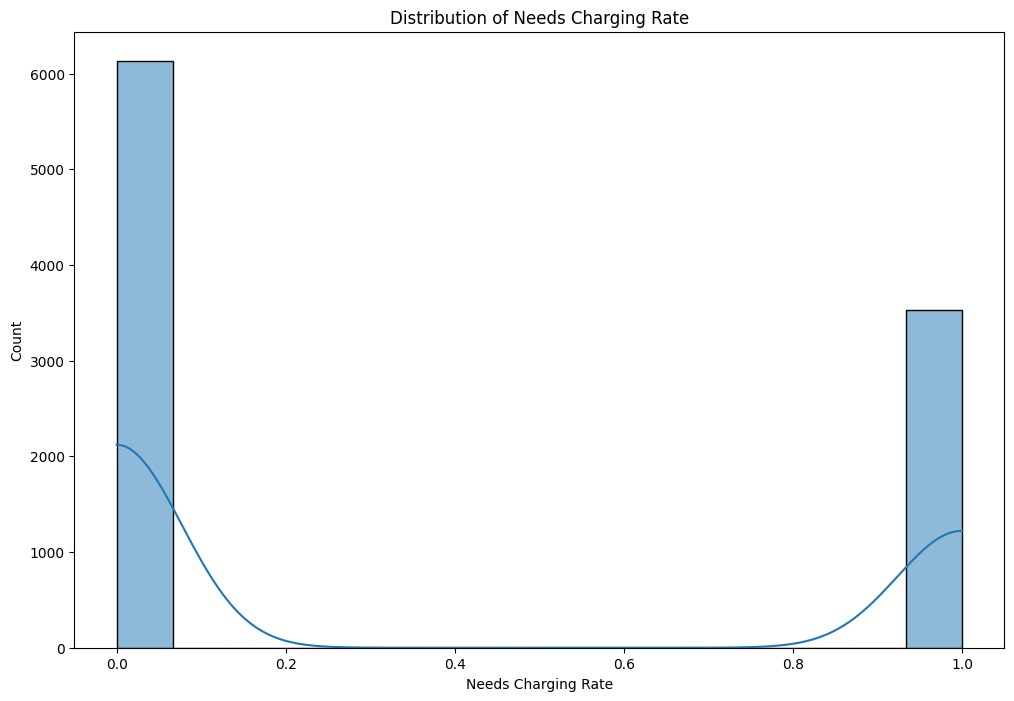

In [14]:
# Distribution of the target variable
plt.figure(figsize=(12,8))
sns.histplot(data['needs_charge'], kde=True)
plt.title('Distribution of Needs Charging Rate')
plt.xlabel('Needs Charging Rate')
plt.ylabel('Count')
plt.show()

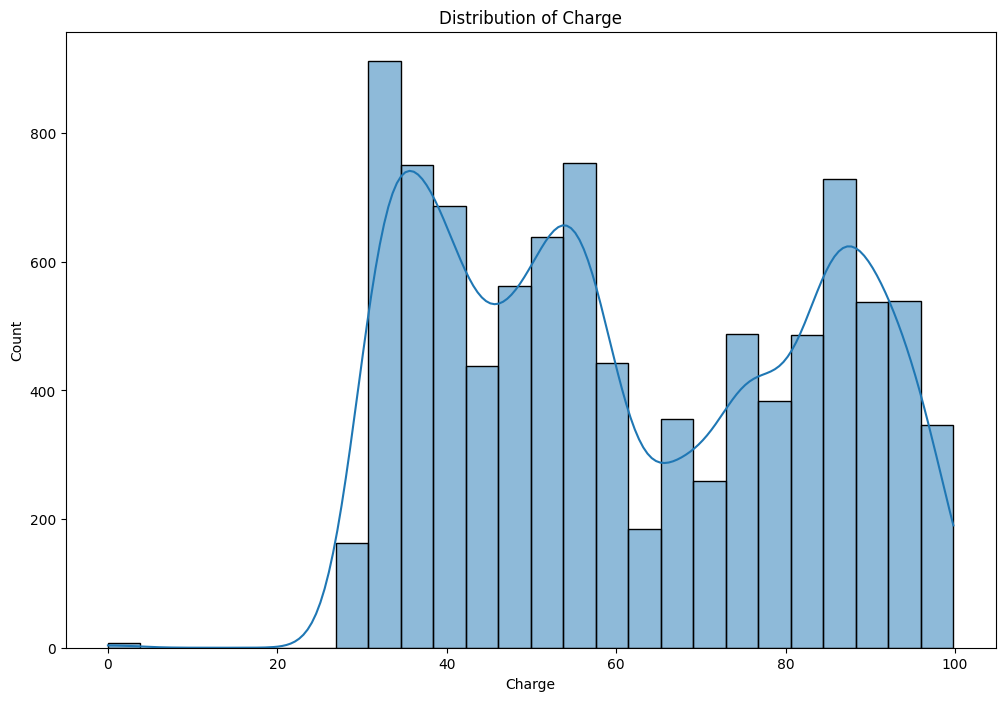

In [15]:
# plot the distribution 
plt.figure(figsize=(12,8))
sns.histplot(data['charge'], kde=True)
plt.title('Distribution of Charge')
plt.xlabel('Charge')
plt.ylabel('Count')
plt.show()


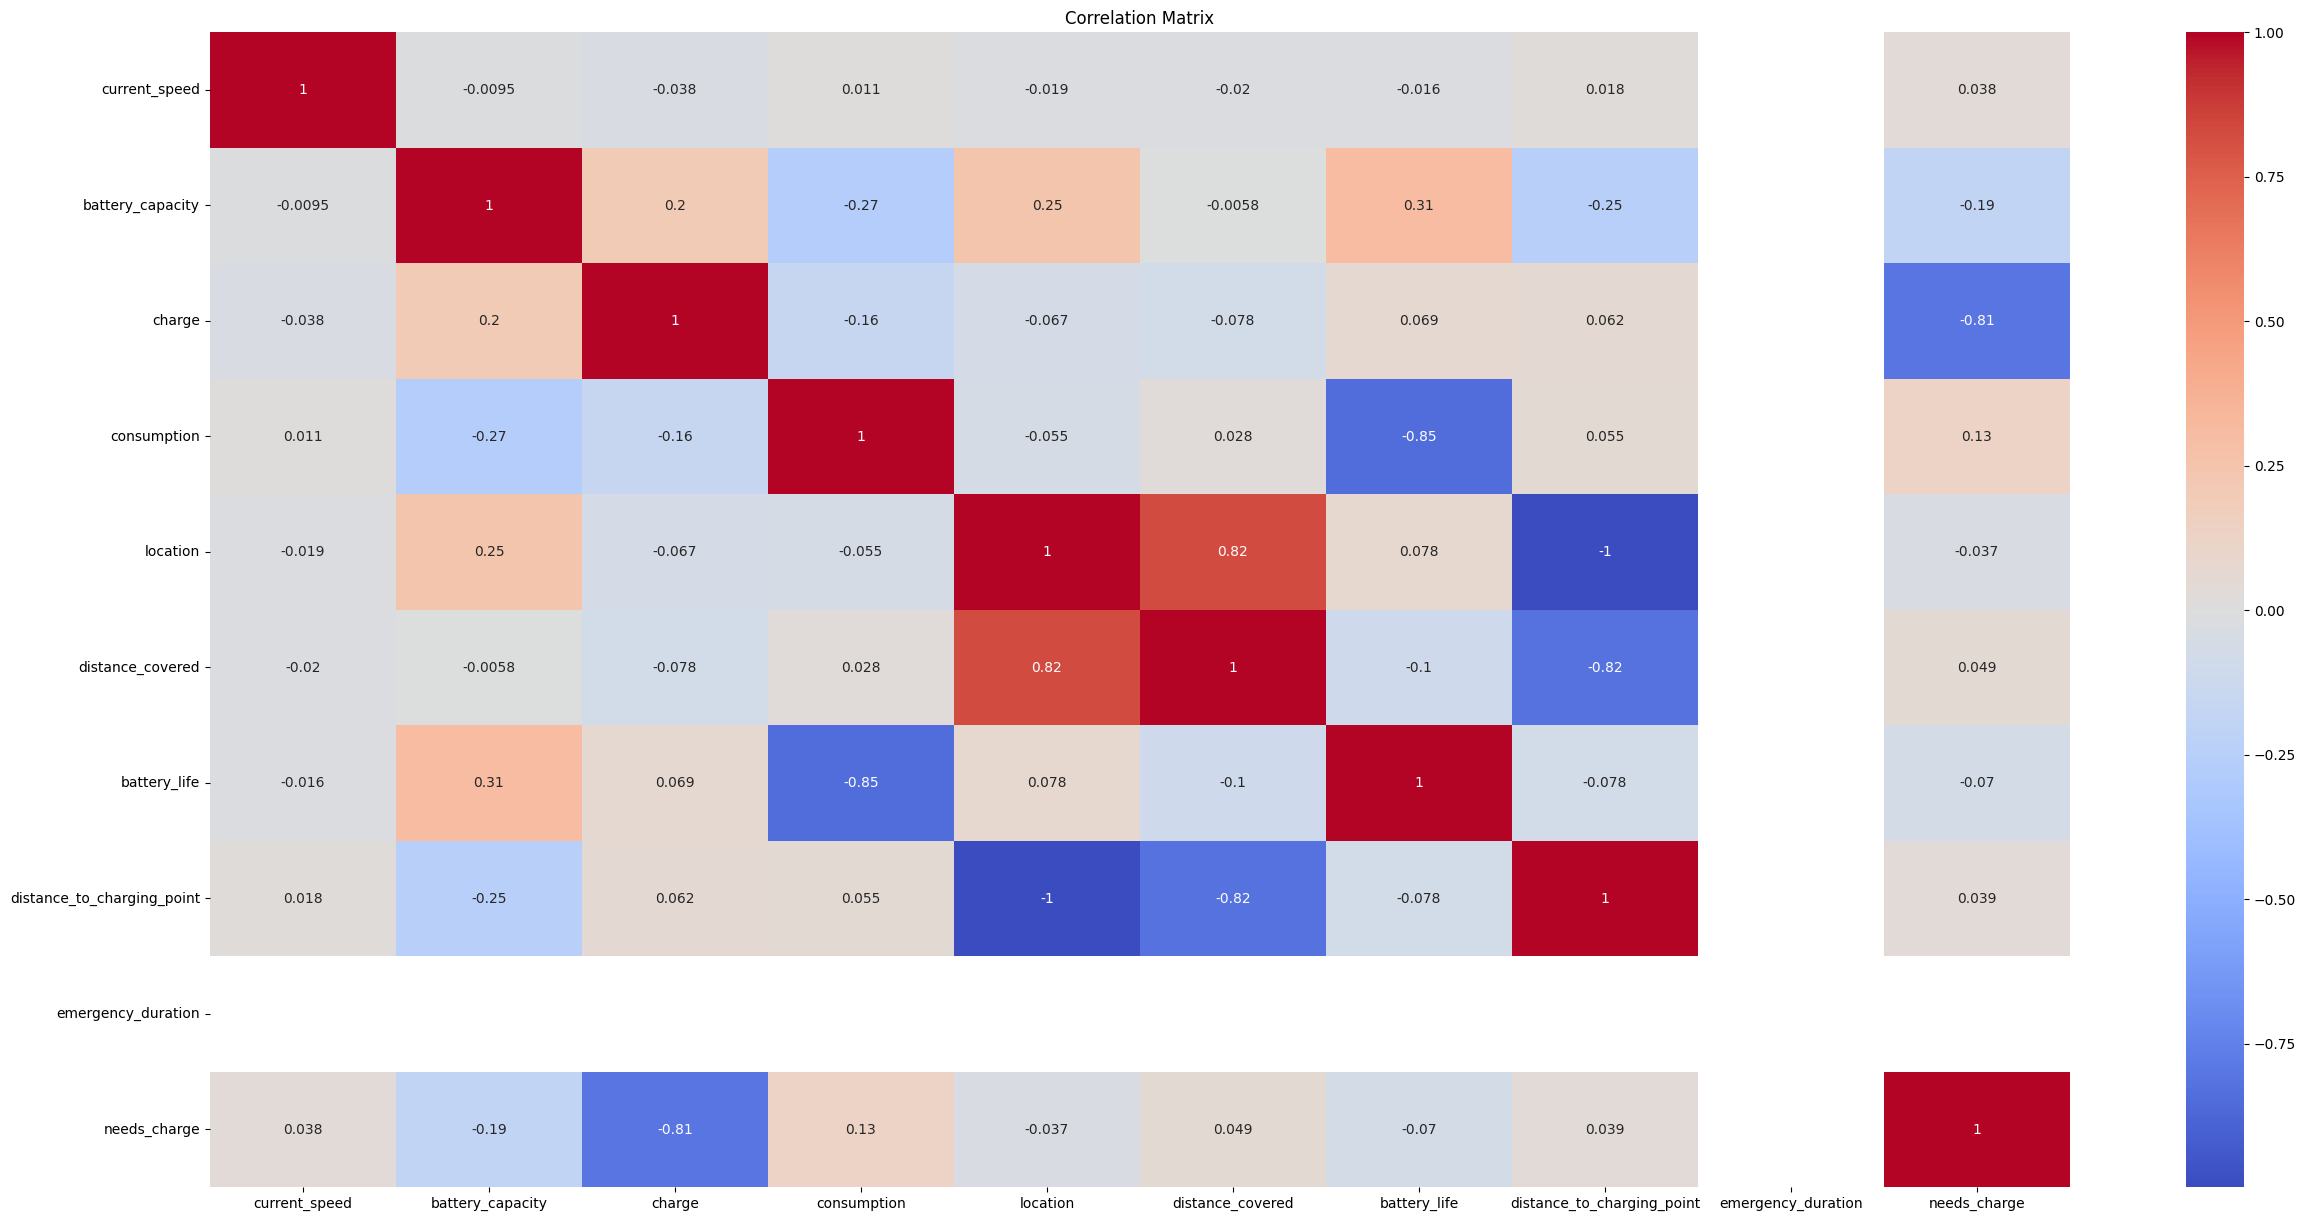

In [16]:
## Correlation Analysis
correlation_matrix = data.corr()
plt.figure(figsize=(30,15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

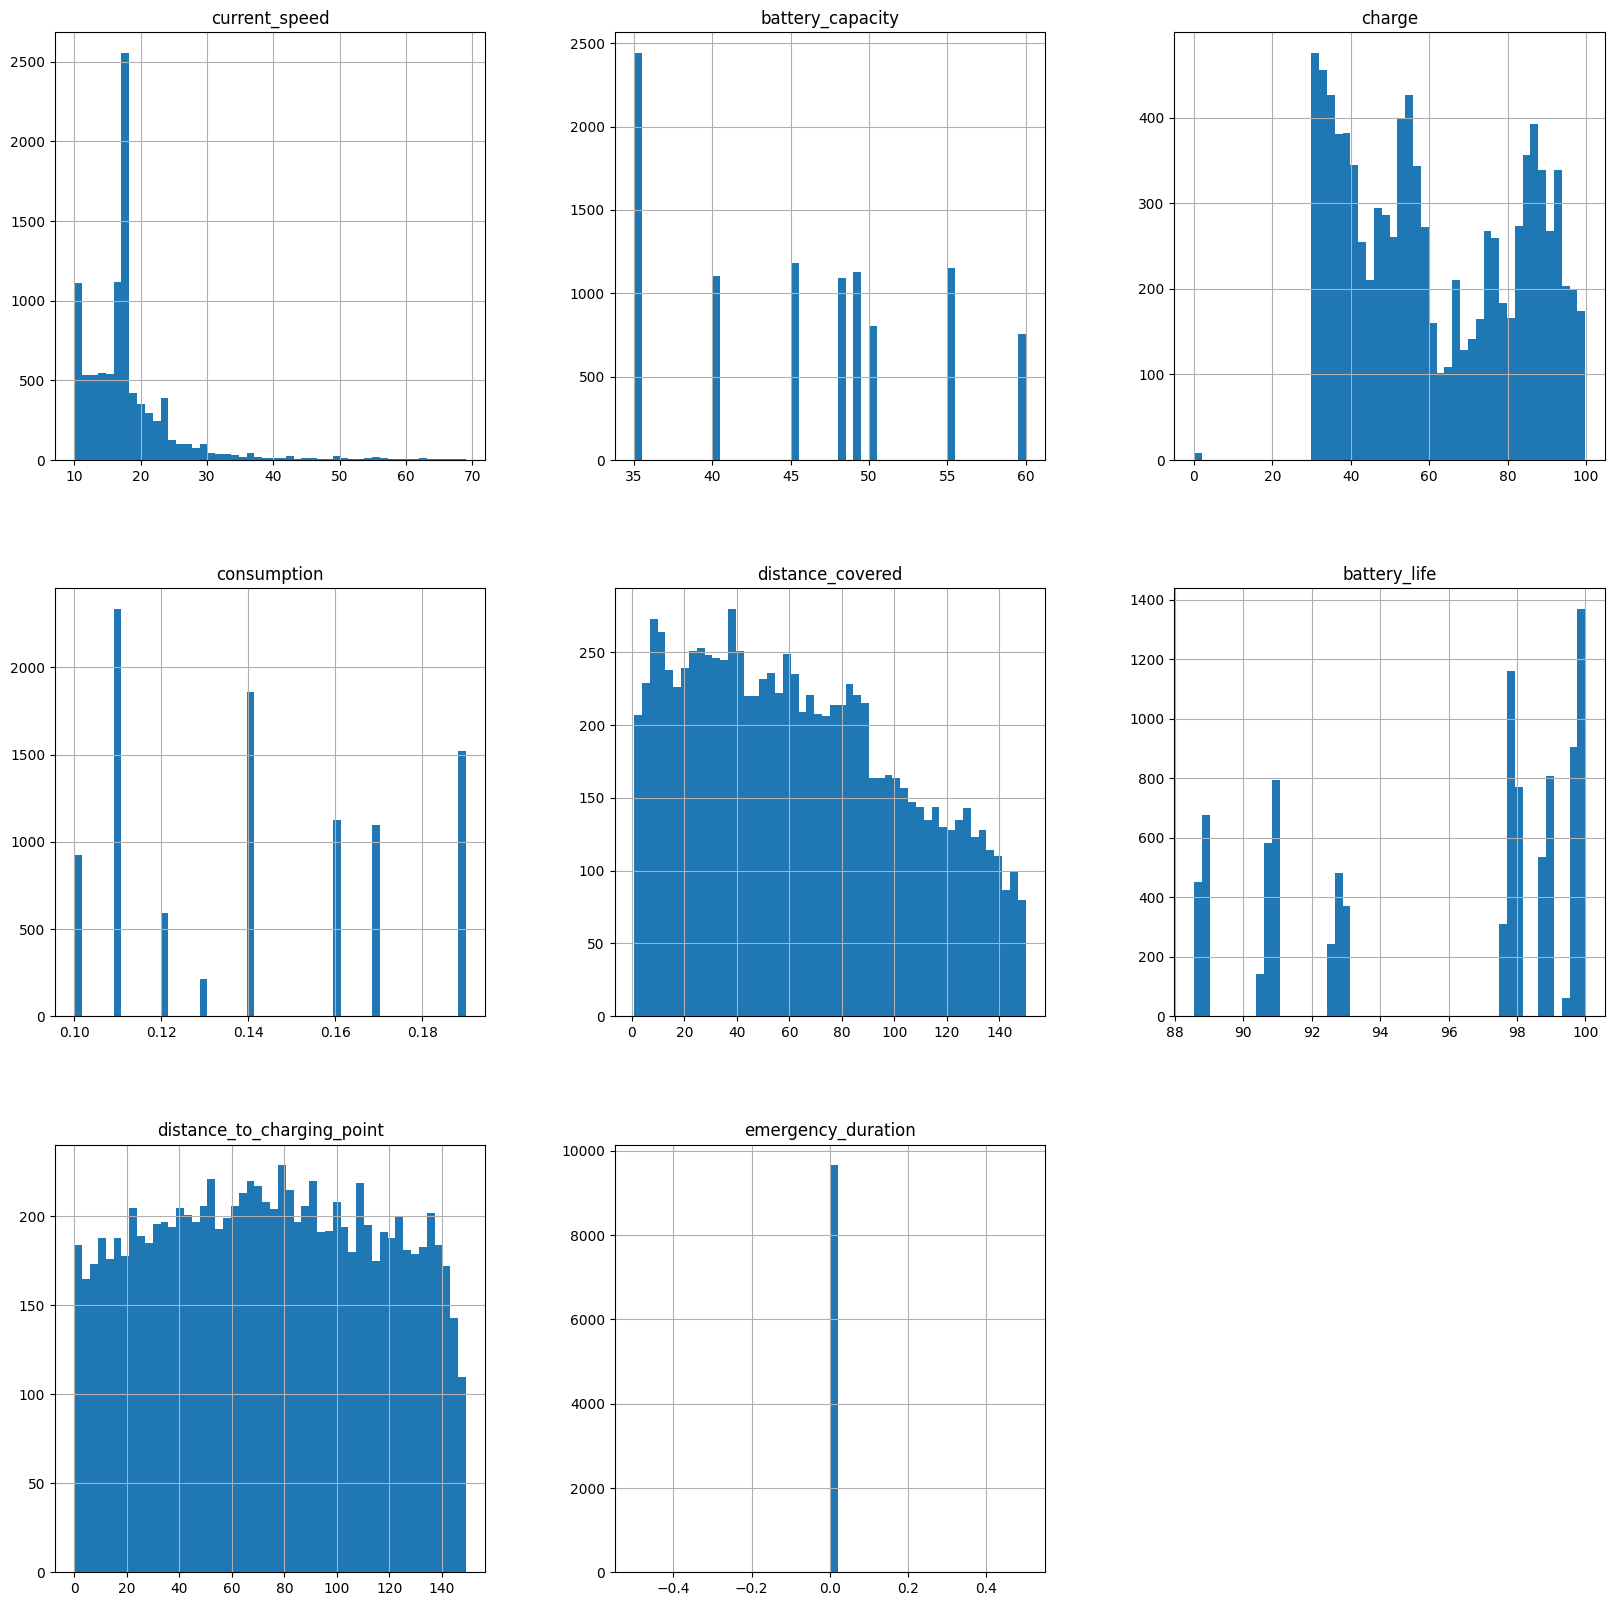

In [17]:
# Visualizing the distribution of the features
# Replace inf with nan
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop nan values
data.dropna(inplace=True)

data[features].hist(figsize=(20, 20), bins=50)
plt.show()

/home/maith/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


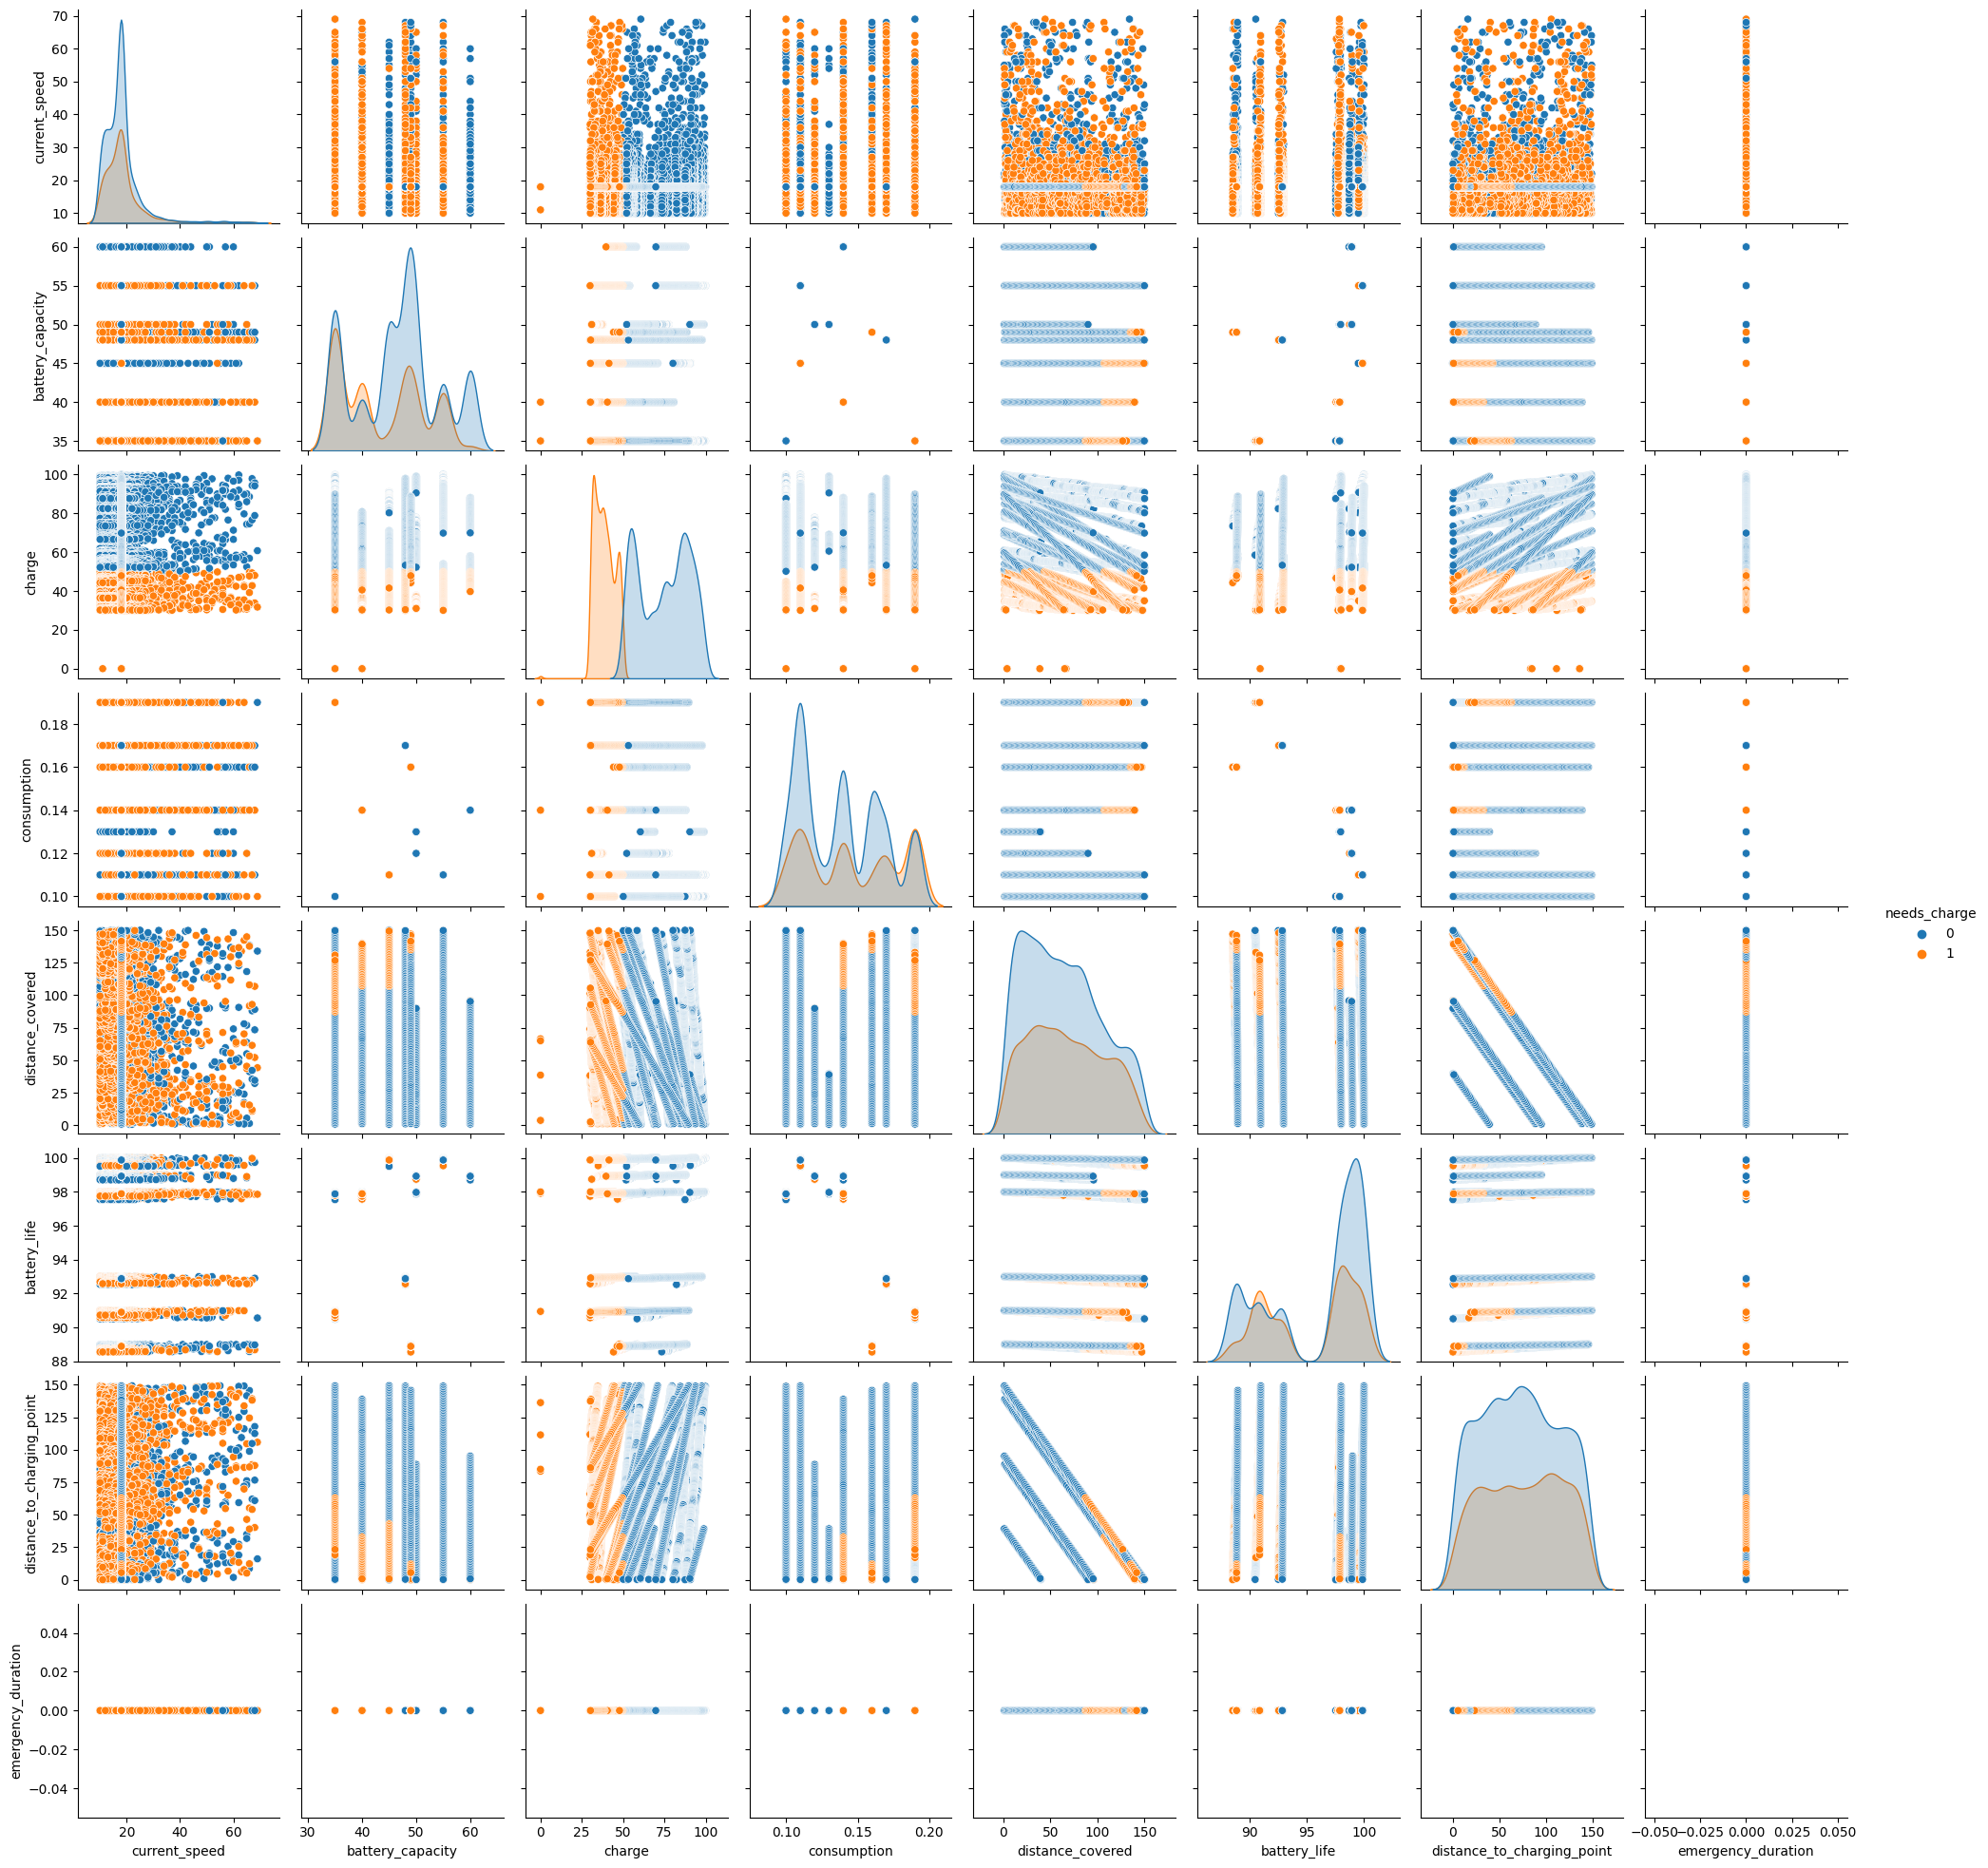

In [18]:
# Pairplot of the features and target variable
sns.pairplot(data[features + ['needs_charge']], hue='needs_charge')
plt.show()

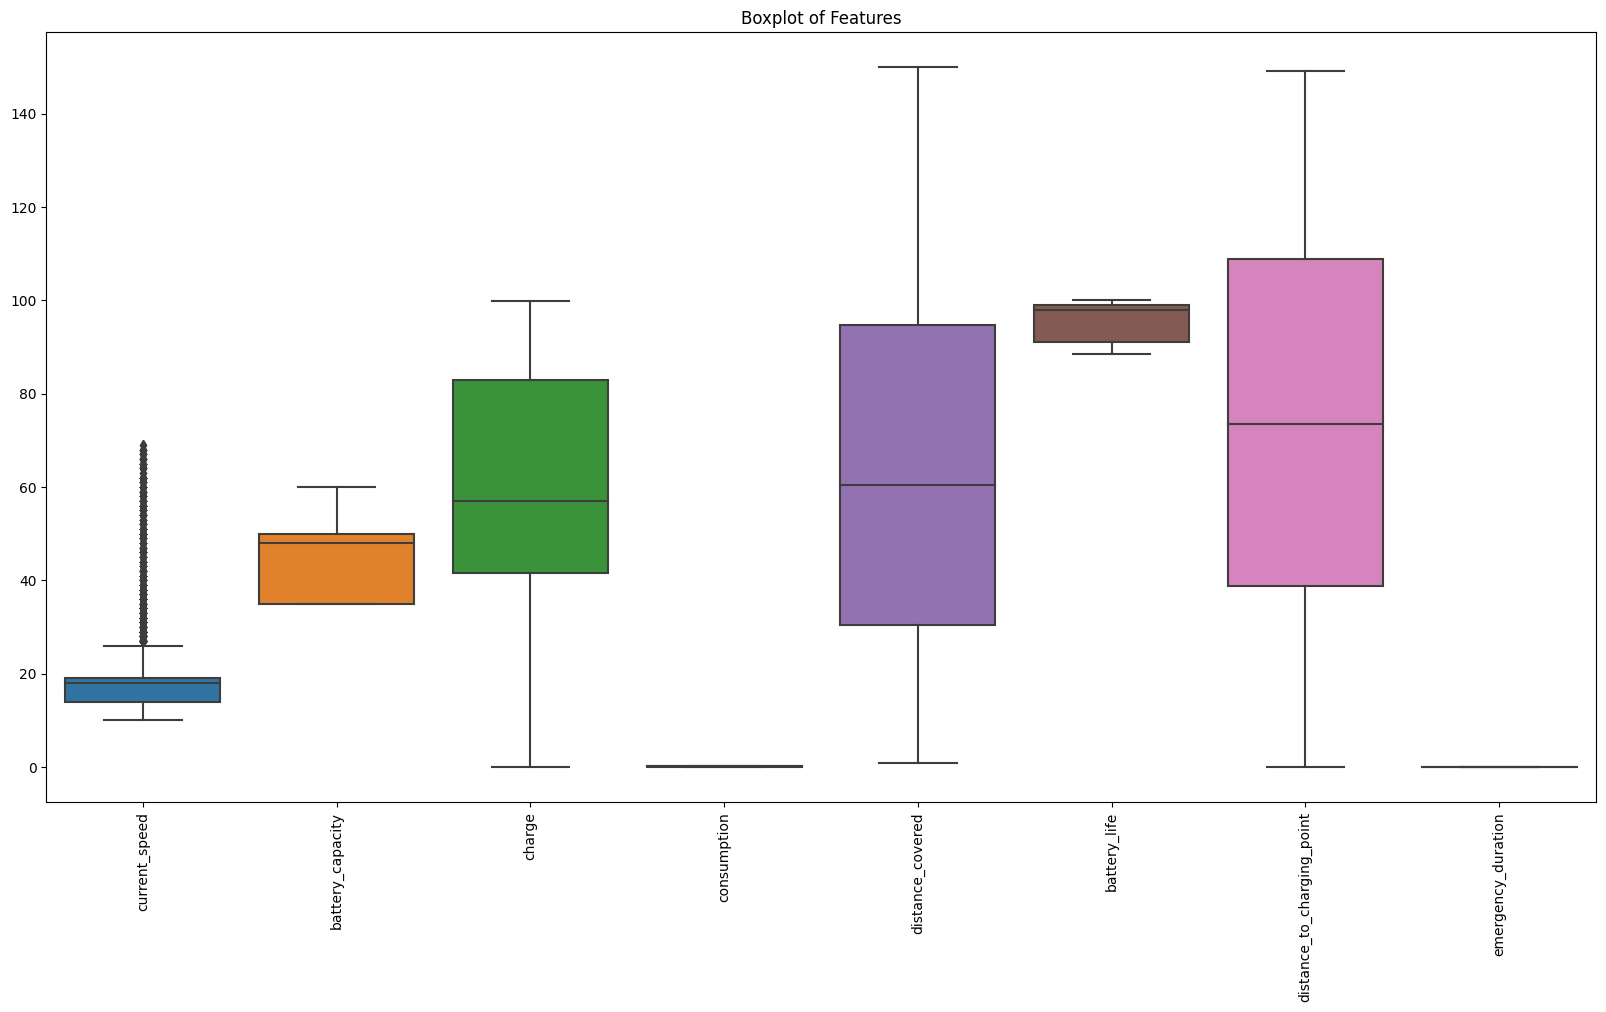

In [19]:
# Boxplots for each feature
plt.figure(figsize=(20, 10))
sns.boxplot(data=data[features])
plt.title('Boxplot of Features')
plt.xticks(rotation=90)
plt.show()

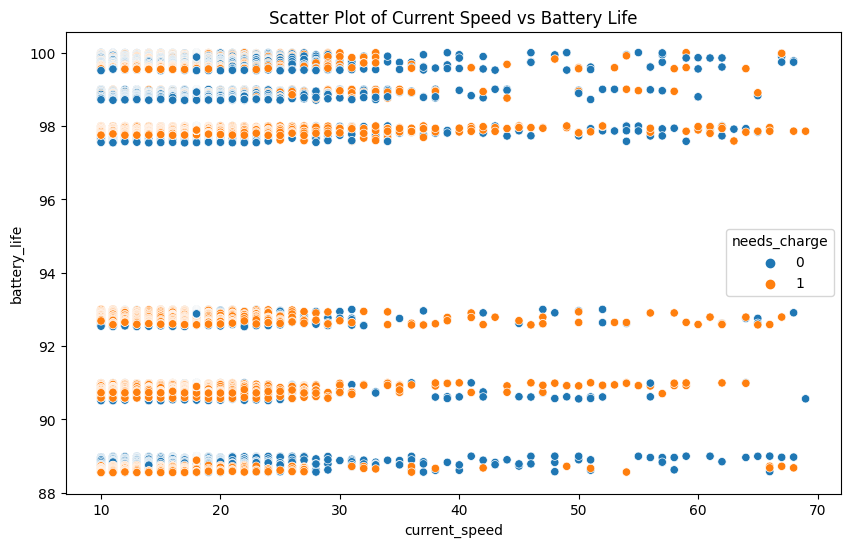

In [20]:
# Scatter plots
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='current_speed', y='battery_life', hue='needs_charge')
plt.title('Scatter Plot of Current Speed vs Battery Life')
plt.show()

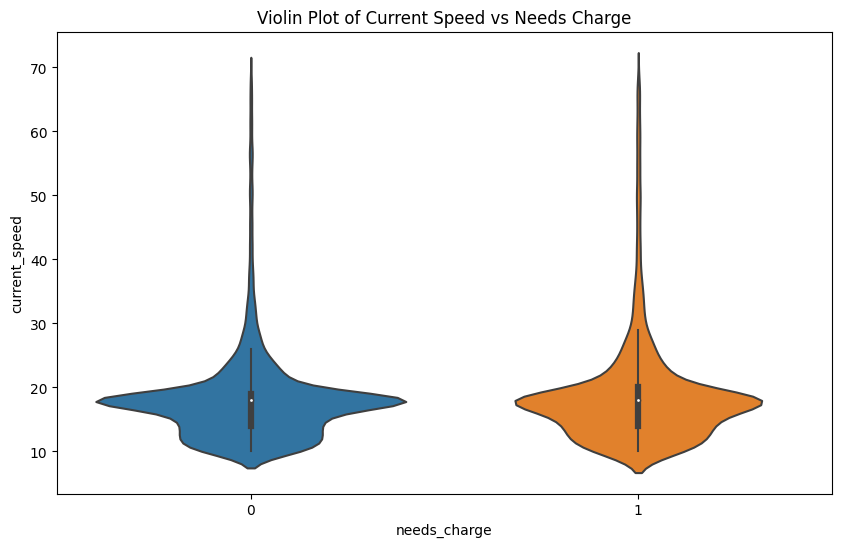

In [21]:
# Violin plots
plt.figure(figsize=(10, 6))
sns.violinplot(x=data['needs_charge'], y=data['current_speed'])
plt.title('Violin Plot of Current Speed vs Needs Charge')
plt.show()

/home/maith/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


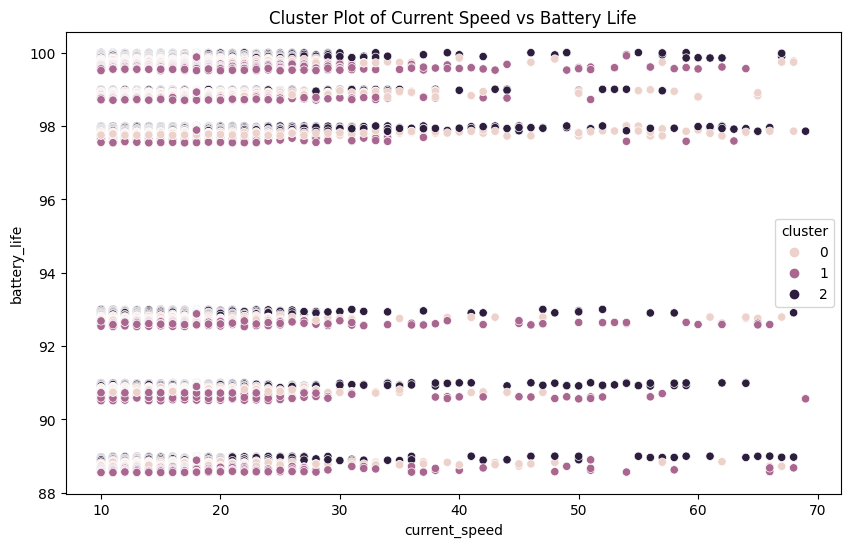

In [22]:
# cluster plot
from sklearn.cluster import KMeans

# Fit the KMeans algorithm to the data
kmeans = KMeans(n_clusters=3)
data['cluster'] = kmeans.fit_predict(data[features])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='current_speed', y='battery_life', hue='cluster')
plt.title('Cluster Plot of Current Speed vs Battery Life')
plt.show()

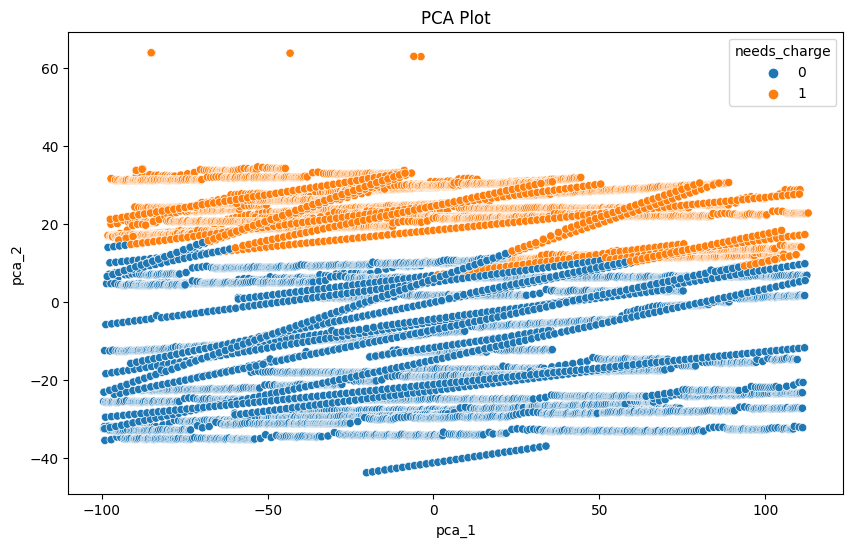

In [23]:
# Dimensionality reduction plot
from sklearn.decomposition import PCA

# Apply PCA to the data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data[features])
data['pca_1'] = pca_result[:, 0]
data['pca_2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='pca_1', y='pca_2', hue='needs_charge')
plt.title('PCA Plot')
plt.show()

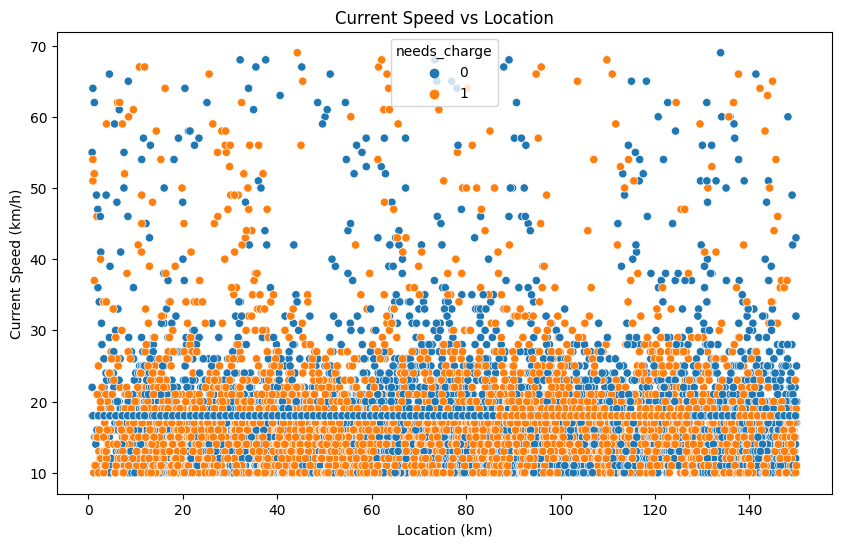

In [24]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='location', y='current_speed', hue='needs_charge')
plt.title('Current Speed vs Location')
plt.xlabel('Location (km)')
plt.ylabel('Current Speed (km/h)')
plt.show()

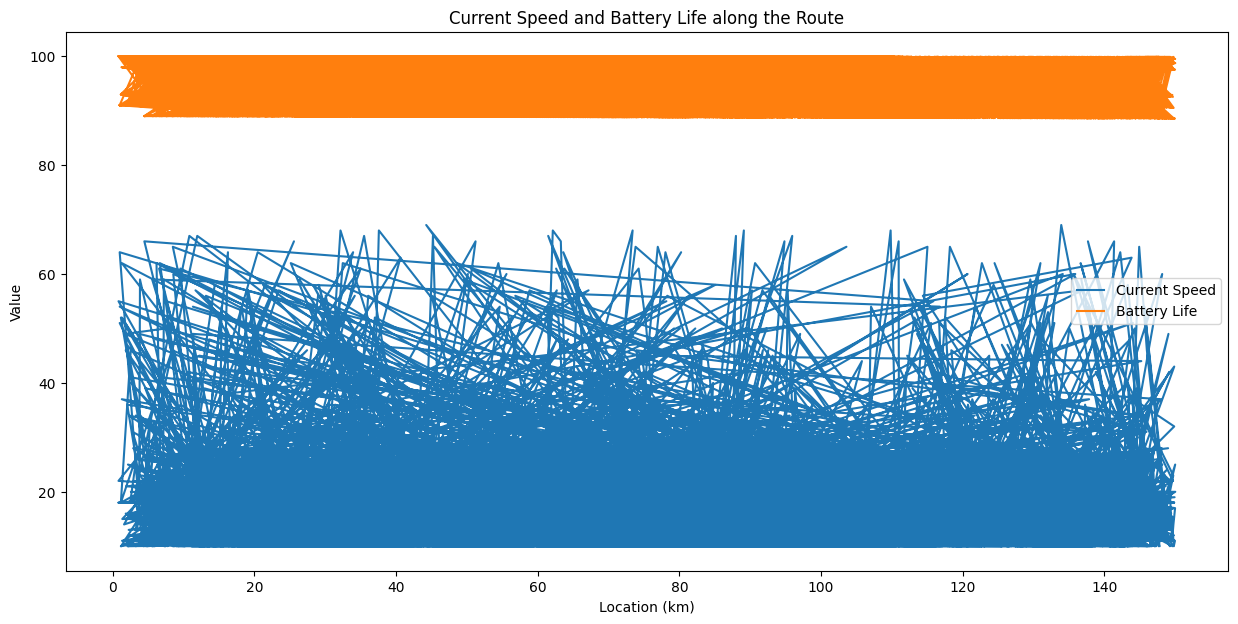

In [25]:
plt.figure(figsize=(15, 7))
plt.plot(data['location'], data['current_speed'], label='Current Speed')
plt.plot(data['location'], data['battery_life'], label='Battery Life')
plt.title('Current Speed and Battery Life along the Route')
plt.xlabel('Location (km)')
plt.ylabel('Value')
plt.legend()
plt.show()

In [26]:
# Use cross_val_score function
# Cross-Validation
scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
print('Cross-Validation Accuracy Scores', scores)
print('Average Cross-Validation Accuracy', scores.mean())


Cross-Validation Accuracy Scores [0.98241986 1.         1.         1.         0.99482402 0.97826087
 1.         0.98757764 0.99585921 0.99792961]
Average Cross-Validation Accuracy 0.993687120097803


In [27]:
# Initialize the constructor
model = Sequential()

In [28]:
# Add an input layer 
model.add(Dense(12, activation='relu', input_shape=(len(X.columns),)))

In [29]:
# Add one hidden layer 
model.add(Dense(8, activation='relu'))

In [30]:
# Add an output layer 
model.add(Dense(1, activation='sigmoid'))

In [31]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                108       
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Define the callbacks
callbacks = [EarlyStopping(patience=10, restore_best_weights=True),
             ModelCheckpoint(filepath='best_model.h5', save_best_only=True)]

In [34]:
# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, 
          validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/100
199/212 [===========================>..] - ETA: 0s - loss: 0.5492 - accuracy: 0.7687

212/212 [==============================] - 1s 2ms/step - loss: 0.5389 - accuracy: 0.7764 - val_loss: 0.3327 - val_accuracy: 0.9234
Epoch 2/100
212/212 [==============================] - 0s 1ms/step - loss: 0.2156 - accuracy: 0.9583 - val_loss: 0.1412 - val_accuracy: 0.9683
Epoch 3/100
212/212 [==============================] - 0s 945us/step - loss: 0.1087 - accuracy: 0.9719 - val_loss: 0.0838 - val_accuracy: 0.9727
Epoch 4/100
212/212 [==============================] - 0s 895us/step - loss: 0.0706 - accuracy: 0.9797 - val_loss: 0.0581 - val_accuracy: 0.9848
Epoch 5/100
212/212 [==============================] - 0s 761us/step - loss: 0.0528 - accuracy: 0.9874 - val_loss: 0.0460 - val_accuracy: 0.9886
Epoch 6/100
212/212 [==============================] - 0s 933us/step - loss: 0.0427 - accuracy: 0.9892 - val_loss: 0.0376 - val_accuracy: 0.9914
Epoch 7/100
212/212 [==============================] - 0s 836us/step - loss: 0.0367 - accuracy: 0.9896 - val_loss: 0.0336 - val_accuracy: 0.9890
E

In [35]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

91/91 [==============================] - 0s 588us/step - loss: 0.0055 - accuracy: 0.9983
Test loss: 0.005499030463397503
Test accuracy: 0.9982752799987793


In [36]:
def predict_need_charge(model, scaler, features):
    # print feature names and their values
       
    # scale the features
    features_scaled = scaler.transform(np.array(features).reshape(1, -1))
    # make prediction
    prediction = model.predict(features_scaled)
    return int(prediction.round())

features = [
    180,  # current_speed
    33,  # battery_capacity
    65,  # charge
    0.2,  # consumption
    400,  # distance_covered
    60,  # battery_life
    80,   # distance_to_charging_point
    0    # emergency_duration
]

prediction = predict_need_charge(model, scaler, features)
if prediction == 1:
    print("The car needs to charge in the next station.")
else:
    print("The car does not need to charge in the next station.")

1/1 [==============================] - 0s 54ms/step
The car needs to charge in the next station.


/home/maith/.local/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [37]:
# save Neural Network model
model.save('neural_network_model_node_1.h5')

# save scaler object
joblib.dump(scaler, 'scaler_node_1.pkl')

['scaler_node_1.pkl']

In [38]:
# load Neural Network model
model = tf.keras.models.load_model('neural_network_model_node_1.h5')

# load scaler object
scaler = joblib.load('scaler_node_1.pkl')

In [39]:
def predict_need_charge(model, scaler, features):
    # scale the features
    features_scaled = scaler.transform(np.array(features).reshape(1, -1))
    # make prediction
    prediction = model.predict(features_scaled)
    return int(prediction.round())

features = [
    80,  # current_speed
    35,  # battery_capacity
    5,  # charge
    0.1,  # consumption
    100,  # distance_covered
    100,  # battery_life
    5,   # distance_to_charging_point
    0    # emergency_duration
]

prediction = predict_need_charge(model, scaler, features)
if prediction == 1:
    print("The car needs to charge in the next station.")
else:
    print("The car does not need to charge in the next station.")


/home/maith/.local/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 38ms/step
The car needs to charge in the next station.
